In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random

import IPython.display as ipd
import librosa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import penn
import scipy
import torch
import torchutil

import promonet

/home/mrm5248/micromamba/envs/promonet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualize formant estimation

In [4]:
def plot_formants(audio):
    plt.figure(figsize=(12, 6))

    # Compute pitch and periodicity
    pitch, periodicity = promonet.preprocess.from_audio(
        audio,
        gpu=0,
        features=['pitch', 'periodicity'])
    pitch, periodicity = pitch.cpu(), periodicity.cpu()

    # Compute formants
    formants = promonet.formants.from_audio(audio, pitch=pitch, gpu=0, max_formants=6).cpu()
    
    # Compute STFT
    features, frequencies = promonet.formants.stft(audio, gpu=0)
    features, frequencies = features.cpu().numpy(), frequencies.cpu().numpy()
    
    # Compute frame times
    times = np.linspace(
        0,
        promonet.convert.samples_to_seconds(audio.shape[-1]),
        features.shape[0])
    
    # Plot STFT
    plt.pcolormesh(times, frequencies[:-1600], features[:-1, :-1601].T)
    plt.yscale('symlog')
    plt.yticks([50, 100, 200, 400, 800], ['50', '100', '200', '400', '800'], fontsize=12)
    plt.xticks(*plt.xticks(), fontsize=12)
    plt.ylim(frequencies[0], 1200)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.xlabel('Time (seconds)', fontsize=16)
    plt.ylabel('Frequency (Hz)', fontsize=16)
    
    # Overlay pitch
    unvoiced = periodicity[0] < promonet.VOICING_THRESHOLD
    x = torch.clone(pitch).squeeze()
    x[unvoiced] = float('nan')
    plt.plot(times, x, linewidth=2, color='black', label='Pitch')
    
    # Overlay formants
    colors = ['orange', 'green', 'red', 'gray', 'yellow', 'teal']
    for i, formant in enumerate(formants):
        x = torch.clone(formant)
        x[unvoiced] = float('nan')
        plt.plot(
            times,
            x,
            linewidth=2,
            color=colors[i],
            linestyle='--',
            label=f'F{i}')

    ipd.display(ipd.Audio(audio, rate=promonet.SAMPLE_RATE))
    plt.savefig('/hemera-storage1/pardo/max/repos/promonet/notebooks/figures/formant-range/formant.png', bbox_inches='tight', pad_inches=0.1)

In [ ]:
dataset = 'vctk'
stems = promonet.load.partition(dataset)['train']
stem = random.choice(stems)
file = promonet.CACHE_DIR / dataset / f'{stem}-100.wav'
audio = promonet.load.audio(file)
while audio.shape[-1] < 10 * promonet.SAMPLE_RATE:
    stem = random.choice(stems)
    file = promonet.CACHE_DIR / dataset / f'{stem}-100.wav'
    audio = promonet.load.audio(file)

In [5]:
# audio = promonet.load.audio('/hemera-storage1/pardo/max/repos/promonet/notebooks/figures/formant-range/_/Original.wav')
audio = promonet.load.audio('/hemera-storage1/pardo/max/test-audio/sitting.wav')[..., int(.2 * promonet.SAMPLE_RATE):int(6.2 * promonet.SAMPLE_RATE)]

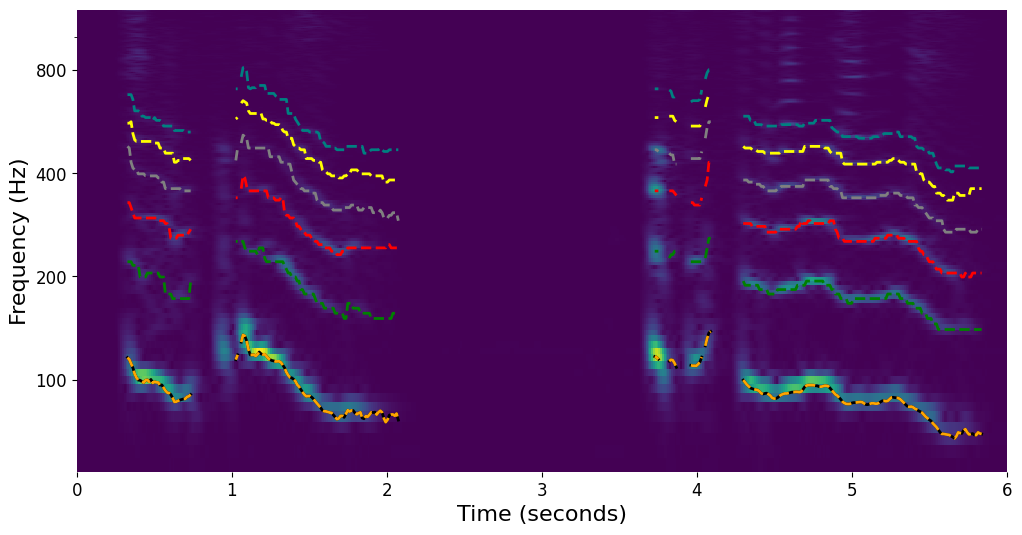

In [6]:
plot_formants(audio)

### Visualize formant editing

In [ ]:
# Formant pitch error plot
file = promonet.EVAL_DIR / 'objective' / 'original' / 'vctk-0037-000088-formant-071-formant.pt'
x = torch.load(file)
x_a = promonet.load.audio(promonet.EVAL_DIR / 'subjective' / 'original' / f'{file.stem.replace("formant-071-formant", "original-100")}.wav')
x_h = torch.load(file.parent / file.name.replace('formant.pt', 'viterbi-periodicity.pt'))
x_s = torch.load(file.parent / f'{file.stem}features.pt')
y = torch.load(file.parent.parent / 'promonet' / file.name)
y_a = promonet.load.audio(promonet.EVAL_DIR / 'subjective' / 'promonet' / f'{file.stem[:-8]}.wav')
y_h = torch.load(file.parent.parent / 'promonet' / file.name.replace('formant.pt', 'viterbi-periodicity.pt'))
y_s = torch.load(file.parent.parent / 'promonet' / f'{file.stem}features.pt')
z = torch.load(file.parent.parent / 'promonet' / file.name.replace('-071-', '-141-'))
z_a = promonet.load.audio(promonet.EVAL_DIR / 'subjective' / 'promonet' / f'{file.stem[:-8].replace("-071", "-141")}.wav')
z_h = torch.load(file.parent.parent / 'promonet' / file.name.replace('formant.pt', 'viterbi-periodicity.pt').replace('-071-', '-141-'))
z_s = torch.load(file.parent.parent / 'promonet' / f'{file.stem}features.pt'.replace('-071-', '-141-'))

# Only evaluate when both predicted and target contain pitch.
# Otherwise, the magnitude of the error can be arbitrarily large.
voicing_xy = (
    penn.voicing.threshold(
        y_h,
        promonet.VOICING_THRESHOLD) &
    penn.voicing.threshold(
        x_h,
        promonet.VOICING_THRESHOLD))
voicing_xz = (
    penn.voicing.threshold(
        z_h,
        promonet.VOICING_THRESHOLD) &
    penn.voicing.threshold(
        x_h,
        promonet.VOICING_THRESHOLD))

# Compute STFT frequencies
frequencies = torch.abs(torch.fft.fftfreq(
    2 * (y_s.shape[0] - 1),
    1 / promonet.SAMPLE_RATE,
    device=y_s.device
)[:y_s.shape[0]])

# Get energy at each formant
x_l = x_s.gather(0, torch.searchsorted(frequencies, x))
y_l = y_s.gather(0, torch.searchsorted(frequencies, y))
z_l = z_s.gather(0, torch.searchsorted(frequencies, z))

# Plot energy change at each formant
colors = ['blue', 'orange', 'green', 'red']
figure, axes = plt.subplots(6, 1, figsize=(16, 8))
for i, (color, xi, yi, zi, x_li, y_li, z_li) in enumerate(zip(colors, x, y, z, x_l, y_l, z_l)):
    x_li[~voicing_xy.squeeze()] = float('nan')
    y_li[~voicing_xy.squeeze()] = float('nan')
    z_li[~voicing_xz.squeeze()] = float('nan')
    axes[-2 * i - 2].plot(x_li, color=color, linestyle='-')
    axes[-2 * i - 2].plot(y_li, color=color, linestyle='--')
    axes[-2 * i - 2].plot(z_li, color=color, linestyle=':')
    axes[-2 * i - 1].plot(y_li - x_li, color=color, linestyle='--')
    axes[-2 * i - 1].plot(z_li - x_li, color=color, linestyle=':')

In [ ]:
# Compute frame times
times = np.linspace(
    0,
    promonet.convert.frames_to_seconds(x_s.shape[-1]),
    x_s.shape[-1])

# Plot STFT
figure, axes = plt.subplots(2, 3, figsize=(16, 16))
axes[0, 0].pcolormesh(times, frequencies[2:], y_s[3:, 1:])
axes[0, 0].set_yscale('symlog')
axes[0, 1].pcolormesh(times, frequencies[2:], x_s[3:, 1:])
axes[0, 1].set_yscale('symlog')
axes[0, 2].pcolormesh(times, frequencies[2:], z_s[3:, 1:])
axes[0, 2].set_yscale('symlog')

diff_xy = y_s[3:, 1:] - x_s[3:, 1:]
diff_xy[diff_xy < 0] = 0.
axes[1, 0].pcolormesh(times, frequencies[2:], diff_xy)
axes[1, 0].set_yscale('symlog')
diff_xz = z_s[3:, 1:] - x_s[3:, 1:]
diff_xz[diff_xz < 0] = 0.
axes[1, 2].pcolormesh(times, frequencies[2:], diff_xz)
axes[1, 2].set_yscale('symlog')

In [ ]:
x_c =(frequencies * x_s.T).sum(dim=1) / x_s.sum(dim=0).squeeze()
y_c = (frequencies * y_s.T).sum(dim=1) / y_s.sum(dim=0).squeeze()
z_c = (frequencies * z_s.T).sum(dim=1) / z_s.sum(dim=0).squeeze()
x_c[~voicing.squeeze()] = float('nan')
y_c[~voicing.squeeze()] = float('nan')
z_c[~voicing.squeeze()] = float('nan')
figure, axes = plt.subplots(2, 1)
axes[0].plot(x_c)
axes[0].plot(y_c)
axes[0].plot(z_c)
axes[1].plot(x_c / y_c, color='orange')
axes[1].plot(z_c / x_c, color='green')

### Evaluate formant editing

In [ ]:
original_directory = promonet.EVAL_DIR / 'objective' / 'original'
original_periodicity_files = sorted(list(original_directory.glob('vctk-*-formant-*-viterbi-periodicity.pt')))
original_formant_files = [file.parent / file.name.replace('viterbi-periodicity', 'formant') for file in original_periodicity_files]
original_spectrogram_files = [file.parent / file.name.replace('viterbi-periodicity', 'formantfeatures') for file in original_periodicity_files]
predicted_directory = promonet.EVAL_DIR / 'objective' / 'promonet'
predicted_periodicity_files = [predicted_directory / file.name for file in original_periodicity_files]
predicted_formant_files = [file.parent / file.name.replace('viterbi-periodicity', 'formant') for file in predicted_periodicity_files]
predicted_spectrogram_files = [file.parent / file.name.replace('viterbi-periodicity', 'formantfeatures') for file in predicted_periodicity_files]

In [ ]:
# Get Pearson correlation statistics
predicted_stats = torchutil.metrics.MeanStd()
target_stats = torchutil.metrics.MeanStd()
for i in range(len(original_spectrogram_files)):

    # Load
    original_periodicity = torch.load(original_periodicity_files[i])
    original_formant = torch.load(original_formant_files[i])
    original_spectrogram = torch.load(original_spectrogram_files[i])
    predicted_periodicity = torch.load(predicted_periodicity_files[i])
    predicted_formant = torch.load(predicted_formant_files[i])
    predicted_spectrogram = torch.load(predicted_spectrogram_files[i])

    # Compute framewise difference of centroids in voiced regions
    original_centroid = promonet.evaluate.metrics.spectral_centroid(original_spectrogram)
    predicted_centroid = promonet.evaluate.metrics.spectral_centroid(predicted_spectrogram)
    voicing = (
        penn.voicing.threshold(
            predicted_periodicity,
            promonet.VOICING_THRESHOLD) &
        penn.voicing.threshold(
            original_periodicity,
            promonet.VOICING_THRESHOLD)
    ).squeeze(0)
    delta = (predicted_centroid / original_centroid)[voicing]

    # Update
    predicted_stats.update(delta)
    target_stats.update(torch.full_like(delta, float(original_periodicity_files[i].stem.split('-')[4]) / 100.))
predicted_stats(), target_stats()

In [ ]:
metric = promonet.evaluate.metrics.Formant(predicted_stats, target_stats)
for i in range(len(original_spectrogram_files)):

    # Load
    original_periodicity = torch.load(original_periodicity_files[i])
    original_formant = torch.load(original_formant_files[i])
    original_spectrogram = torch.load(original_spectrogram_files[i])
    predicted_periodicity = torch.load(predicted_periodicity_files[i])
    predicted_formant = torch.load(predicted_formant_files[i])
    predicted_spectrogram = torch.load(predicted_spectrogram_files[i])

    # Update
    metric.update(
        predicted_formant,
        predicted_periodicity,
        predicted_spectrogram,
        original_formant,
        original_periodicity,
        original_spectrogram,
        float(original_periodicity_files[i].stem.split('-')[4]) / 100.)
metric()

In [ ]:
world_pitch, spectrogram, aperiodicity = promonet.baseline.world.analyze(
    audio.numpy().squeeze(),
    promonet.convert.samples_to_frames(audio.shape[-1]))
plt.plot(world_pitch)
plt.plot(pitch.squeeze())